Want:

main/control loss for:

- GSAE
- GSAE finetune
- GSAE-phys (sweep L0)
- GSAE + SSAE (sweep L0)
- clean loss

In [2]:
import sys
sys.path.append("/root/specialised-SAEs")
from datasets import load_dataset
from transformer_lens import utils, HookedTransformer
import gc
import torch
import matplotlib.pyplot as plt
from load_sae_from_hf import load_sae_from_hf

In [3]:
DTYPE = "bfloat16"

In [24]:
# model = HookedTransformer.from_pretrained("gpt2-small", device="cuda", dtype=DTYPE)

Loaded pretrained model gpt2-small into HookedTransformer


In [5]:
subject = "hs_bio_cleaned"
gsae_ft_list = [load_sae_from_hf(f"jacobcd52/gemma-2b-it-gsae-ft-{subject}",
                                f"gsaefinetune_gemma-2b-it_layer12_{subject}_l1={l1}_expansion=16_tokens=8192000.safetensors",
                                f"gsaefinetune_gemma-2b-it_layer12_{subject}_l1={l1}_expansion=16_tokens=8192000_cfg.json",
                                device="cuda", dtype=DTYPE)
            for l1 in [4, 2, 1]]
# Load SAEs, model and dataset
gsae = load_sae_from_hf("jacobcd52/gemma2-gsae", 
                        "sae_weights.safetensors", 
                        "cfg.json",
                        device="cuda", dtype=DTYPE)

(…)1=4_expansion=16_tokens=8192000_cfg.json:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

(…)1=2_expansion=16_tokens=8192000_cfg.json:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

(…)1=1_expansion=16_tokens=8192000_cfg.json:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

cfg.json:   0%|          | 0.00/786 [00:00<?, ?B/s]

In [44]:
(gsae_ft_list[2].b_gate - gsae.b_gate).topk(50, largest=True)

torch.return_types.topk(
values=tensor([0.1621, 0.1484, 0.1270, 0.1245, 0.1221, 0.1206, 0.1191, 0.1187, 0.1162,
        0.1147, 0.1147, 0.1123, 0.1118, 0.1118, 0.1113, 0.1104, 0.1099, 0.1099,
        0.1050, 0.1035, 0.1030, 0.1030, 0.1025, 0.1025, 0.1016, 0.1001, 0.0996,
        0.0981, 0.0977, 0.0972, 0.0967, 0.0962, 0.0952, 0.0947, 0.0947, 0.0947,
        0.0942, 0.0933, 0.0928, 0.0913, 0.0913, 0.0908, 0.0903, 0.0898, 0.0894,
        0.0884, 0.0879, 0.0874, 0.0874, 0.0874], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<TopkBackward0>),
indices=tensor([24570, 14892, 23785,  7048,  6680, 13299,  3675, 16153, 24840, 14609,
        20205, 30465, 19793, 23829, 30669, 32536,  9485, 28765,  9898, 10996,
        22765, 25586,  3897, 19352, 31599,  5280, 24215, 16663, 22464, 16658,
        10284,  1738, 10372, 12504, 17582, 25794, 26452, 27322, 30380,  6644,
        10544,  4674, 30159, 16808,  9960,  9999, 17446, 11303, 16326, 28260],
       device='cuda:0'))

In [73]:
mag_diff_vals, mag_diff_inds = (gsae_ft_list[2].b_mag - gsae.b_mag).sort(descending=True)
gate_diff_vals, gate_diff_inds = (gsae_ft_list[2].b_gate - gsae.b_gate).sort(descending=True)

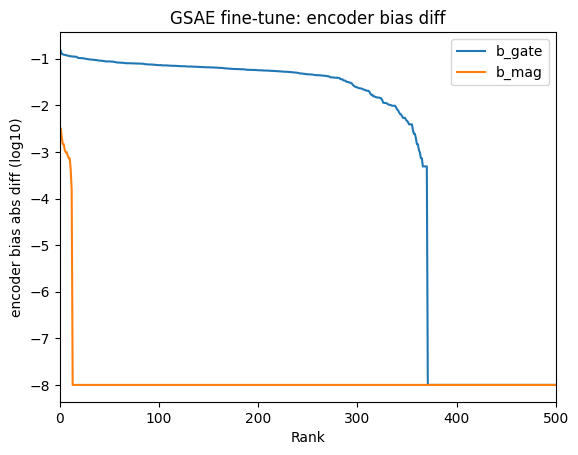

In [89]:
plt.plot((gate_diff_vals.abs().detach().float()+1e-8).log10().cpu().numpy())
plt.plot((mag_diff_vals.abs().detach().float()+1e-8).log10().cpu().numpy())

# set x range
plt.xlim(0, 500)

# label x ad y axes
plt.xlabel("Rank")
plt.ylabel("encoder bias abs diff (log10)")

#title
plt.title("GSAE fine-tune: encoder bias diff")

# add legend
plt.legend(["b_gate", "b_mag"])


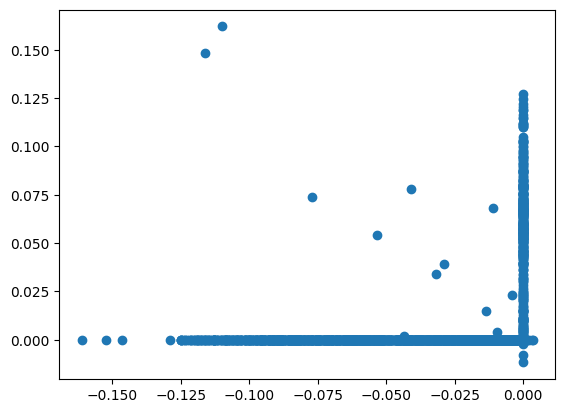

In [57]:
mag_diffs = (gsae_ft_list[2].b_mag - gsae.b_mag).cpu().detach().float()
gate_diffs = (gsae_ft_list[2].b_gate - gsae.b_gate).cpu().detach().float()

# scatter plot of gate_diffs vs mag_diffs
plt.scatter(mag_diffs, gate_diffs)

In [4]:
ssae_dec = ssae.W_dec / ssae.W_dec.norm(dim=1, keepdim=True)
ssae_enc = ssae.W_enc / ssae.W_enc.norm(dim=0, keepdim=True)
gsae_dec = gsae.W_dec / gsae.W_dec.norm(dim=1, keepdim=True)
gsae_enc = gsae.W_enc / gsae.W_enc.norm(dim=0, keepdim=True)
ft_dec = ft.W_dec / ft.W_dec.norm(dim=1, keepdim=True)
ft_enc = ft.W_enc / ft.W_enc.norm(dim=0, keepdim=True)

In [43]:
ssae_dec_maxsims = (ssae_dec @ gsae_dec.T).max(dim=1).values
ssae_enc_maxsims = (ssae_enc.T @ gsae_enc).max(dim=1).values

ft_dec_maxsims = (ft_dec @ gsae_dec.T).max(dim=1).values
ft_enc_maxsims = (ft_enc.T @ gsae_enc).max(dim=1).values
ssae_dec_maxsims.shape, ssae_enc_maxsims.shape, ft_dec_maxsims.shape, ft_enc_maxsims.shape

rand_dec = torch.randn_like(gsae_dec)
rand_dec /= rand_dec.norm(dim=1, keepdim=True)
print(rand_dec.shape)

rand_dec2 = torch.randn_like(ssae_dec)
rand_dec2 /= rand_dec2.norm(dim=1, keepdim=True)
print(rand_dec2.shape)

rand_dec_maxsims = (rand_dec @ rand_dec2.T).max(dim=0).values
rand_dec_maxsims.shape

torch.Size([32768, 2048])
torch.Size([4096, 2048])


torch.Size([4096])

(array([  1.,   0.,   2.,   4.,  13.,   7.,  22.,  17.,  34.,  32.,  74.,
         64.,  76., 105., 108., 119., 130., 109., 158., 143., 143., 178.,
        146., 141., 130., 126., 138., 160., 124., 128., 142., 111.,  99.,
         91.,  96.,  95.,  82.,  63.,  66.,  58.,  58.,  69.,  43.,  42.,
         32.,  41.,  31.,  19.,  30.,  26.,  15.,  20.,  13.,  10.,  13.,
         13.,   8.,   7.,  15.,   9.,   5.,   7.,   2.,   4.,   1.,   4.,
          3.,   0.,   3.,   1.,   3.,   2.,   1.,   0.,   1.,   3.,   1.,
          3.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.07663212, 0.07716014, 0.07768817, 0.0782162 , 0.07874422,
        0.07927225, 0.07980027, 0.0803283 , 0.08085632, 0.08138435,
        0.08191238, 0.0824404 , 0.08296842, 0.08349645, 0.08402447,
        0.0845525 , 0.08508053, 0.08560855, 0.08613658, 0.0866646 ,
        0.08719262, 0.08772065, 0.08824868, 0.

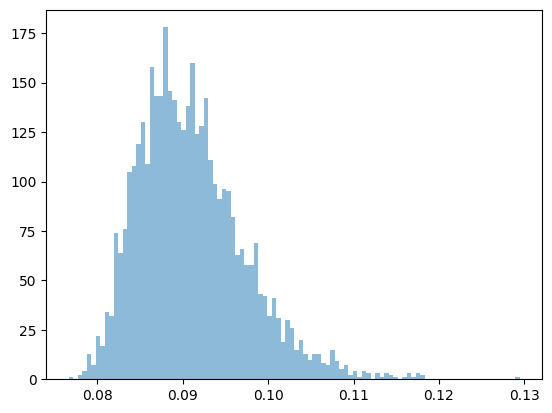

In [44]:
plt.hist(rand_dec_maxsims.detach().cpu().numpy(), bins=100, alpha=0.5, label="ssae")

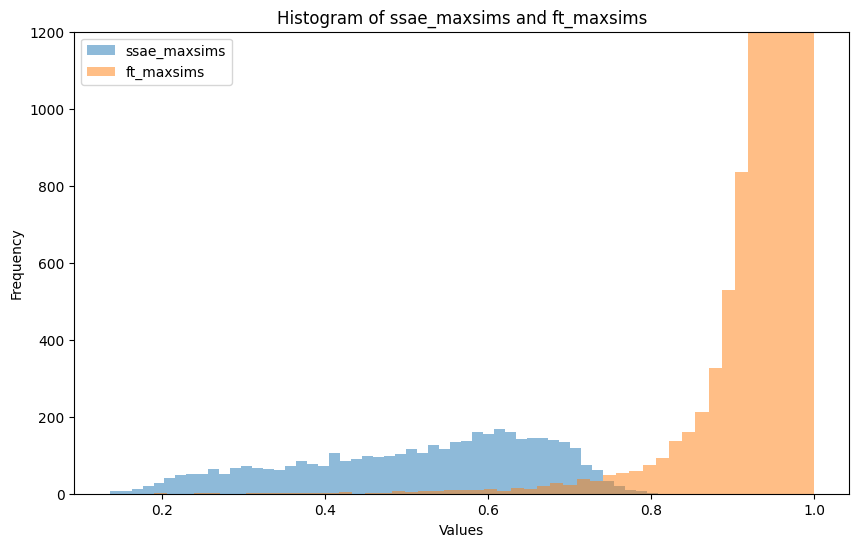

In [19]:
ssae_maxsims_cpu = ssae_dec_maxsims.cpu().detach().numpy()
ft_maxsims_cpu = ft_dec_maxsims.cpu().detach().numpy()

plt.figure(figsize=(10, 6))
plt.hist(ssae_maxsims_cpu, bins=50, alpha=0.5, label='ssae_maxsims')
plt.hist(ft_maxsims_cpu, bins=50, alpha=0.5, label='ft_maxsims')
plt.ylim(0, 1200)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of ssae_maxsims and ft_maxsims')
plt.legend()
plt.show()

In [ ]:
ssae_maxsims_cpu = ssae_dec_maxsims.cpu().detach().numpy()
ft_maxsims_cpu = ft_dec_maxsims.cpu().detach().numpy()

plt.figure(figsize=(10, 6))
plt.hist(ssae_maxsims_cpu, bins=50, alpha=0.5, label='ssae_maxsims')
plt.hist(ft_maxsims_cpu, bins=50, alpha=0.5, label='ft_maxsims')
plt.ylim(0, 1200)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of ssae_maxsims and ft_maxsims')
plt.legend()
plt.show()

In [21]:
W_dec = torch.randn_like(ssae.W_dec)
W_dec /= W_dec.norm(dim=1, keepdim=True)

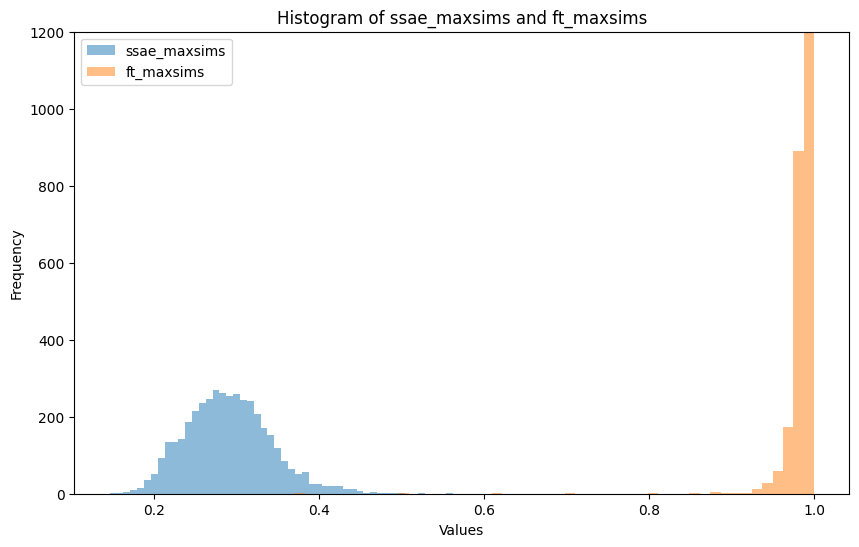

In [20]:
ssae_maxsims_cpu = ssae_enc_maxsims.cpu().detach().numpy()
ft_maxsims_cpu = ft_enc_maxsims.cpu().detach().numpy()

plt.figure(figsize=(10, 6))
plt.hist(ssae_maxsims_cpu, bins=50, alpha=0.5, label='ssae_maxsims')
plt.hist(ft_maxsims_cpu, bins=50, alpha=0.5, label='ft_maxsims')
plt.ylim(0, 1200)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of ssae_maxsims and ft_maxsims')
plt.legend()
plt.show()

In [48]:
diff_dec = gsae_dec - ft_dec
diff_dec.shape

In [55]:
# create UMAP of diff_dec
import umap
import numpy as np
# create the UMAP


AttributeError: module 'umap' has no attribute 'UMAP'